In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Metric evaluation

In [ ]:
# Hitrate@10 evaluation function
def hitrate_at_k(true_data: pd.DataFrame,
                 predicted_data: pd.DataFrame,
                 k: int = 10) -> float:
    """
    This function calculates the hitrate at k for the recommendations.
    It assesses how relevant our 10 product recommendations are.
    In other words, it calculates the proportion of recommended products that are actually purchased by the customer.

    Args:
        true_data: a pandas DataFrame containing the true data
            customer_id: the customer identifier
            product_id: the product identifier that was purchased in the test set
        predicted_data: a pandas DataFrame containing the predicted data
            customer_id: the customer identifier
            product_id: the product identifier that was recommended
            rank: the rank of the recommendation. the rank should be between 1 and 10.
        k: the number of recommendations to consider. k should be between 1 and 10.

    Returns:
        The hitrate at k
    """

    data = pd.merge(left = true_data, right = predicted_data, how = "left", on = ["customer_id", "product_id"])
    df = data[data["rank"] <= k]
    non_null_counts = df.groupby('customer_id')['rank'].apply(lambda x: x.notna().sum()).reset_index(name='non_null_count')
    distinct_products_per_customer = data.groupby('customer_id')['product_id'].nunique().reset_index(name='distinct_product_count')
    df = pd.merge(left = distinct_products_per_customer, right = non_null_counts, how = "left", on = "customer_id")
    df["denominator"] = [min(df.iloc[i].distinct_product_count,k) for i in range(len(df))]
    df = df.fillna(0)
    return (df["non_null_count"]/df["denominator"]).mean()

# Load Data
train_data

products_data

test_data

In [2]:
train_dataframes = []
for i in tqdm(range(1, 11)):
    train_dataframes.append(pd.read_csv(f'/kaggle/input/product-re-purchase-prediction/data-train/data-train/train_data_part_{i}.csv'))
#train_dataframes.append(pd.read_csv(f'/kaggle/input/product-re-purchase-prediction/data-train/data-train/train_data_part_7.csv'))
train_data = pd.concat(train_dataframes, ignore_index=True)

del train_dataframes

products_data = pd.read_csv('/kaggle/input/product-re-purchase-prediction/data-train/data-train/products_data.csv', low_memory=False)
test_data = pd.read_csv('/kaggle/input/product-re-purchase-prediction/data-train/data-train/test_data.csv')

100%|██████████| 10/10 [04:47<00:00, 28.71s/it]


## Years + Recently

data_2022

data_2023

In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'])

# Add recency attribute
latest_date = train_data['date'].max()  # Find the latest date in the dataset
train_data['recency'] = (latest_date - train_data['date']).dt.days  # Calculate days since last purchase

# Group by customer_id and product_id to calculate quantity and most recent purchase
customer_product_data = train_data.groupby(['customer_id', 'product_id']).agg({
    'quantity': 'sum',
    'recency': 'min'  # Minimum days since purchase (most recent)
}).reset_index()

# Normalize quantity and recency scores
customer_product_data['quantity_score'] = customer_product_data['quantity'] / customer_product_data['quantity'].max()
customer_product_data['recency_score'] = 1 - (customer_product_data['recency'] / customer_product_data['recency'].max())  # Recent = higher score

# Merge frequency data into customer_product_data
frequency = train_data.groupby(['customer_id', 'product_id'])['transaction_id'].count().reset_index(name='frequency')
customer_product_data = customer_product_data.merge(frequency, on=['customer_id', 'product_id'], how='left')

# Fill any missing frequency values (if any product has no transactions counted, assume 0)
customer_product_data['frequency'] = customer_product_data['frequency'].fillna(0)

# Normalize frequency score
customer_product_data['frequency_score'] = customer_product_data['frequency'] / customer_product_data['frequency'].max()


# Split data into 2022 and 2023 subsets
data_2022 = train_data[train_data['date'].dt.year == 2022]
data_2023 = train_data[train_data['date'].dt.year == 2023]

# Data Analyze

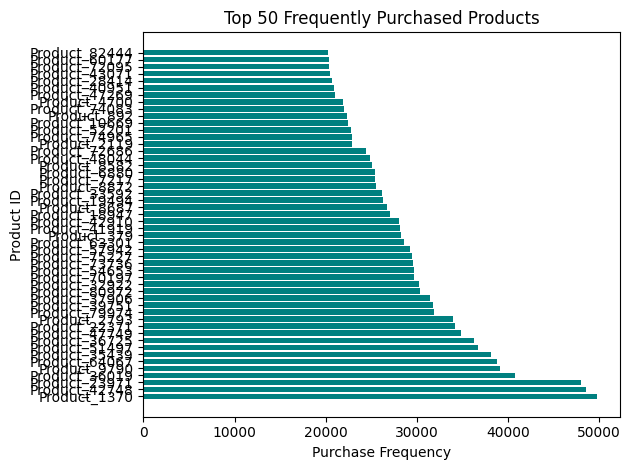

In [6]:
# Calculate the frequency of purchases for each product
product_purchase_frequency = train_data.groupby('product_id')['customer_id'].nunique().reset_index(name='frequency')

# Sort products based on frequency (in descending order)
product_purchase_frequency = product_purchase_frequency.sort_values(by='frequency', ascending=False)

# Top 50 most frequently purchased products
top_50_frequent_products = product_purchase_frequency.head(50)

# Overall top 50 frequently purchased products
plt.barh(top_50_frequent_products['product_id'].astype(str), 
             top_50_frequent_products['frequency'], color='teal')
plt.title('Top 50 Frequently Purchased Products')
plt.xlabel('Purchase Frequency')
plt.ylabel('Product ID')

# Adjust layout
plt.tight_layout()
plt.show()

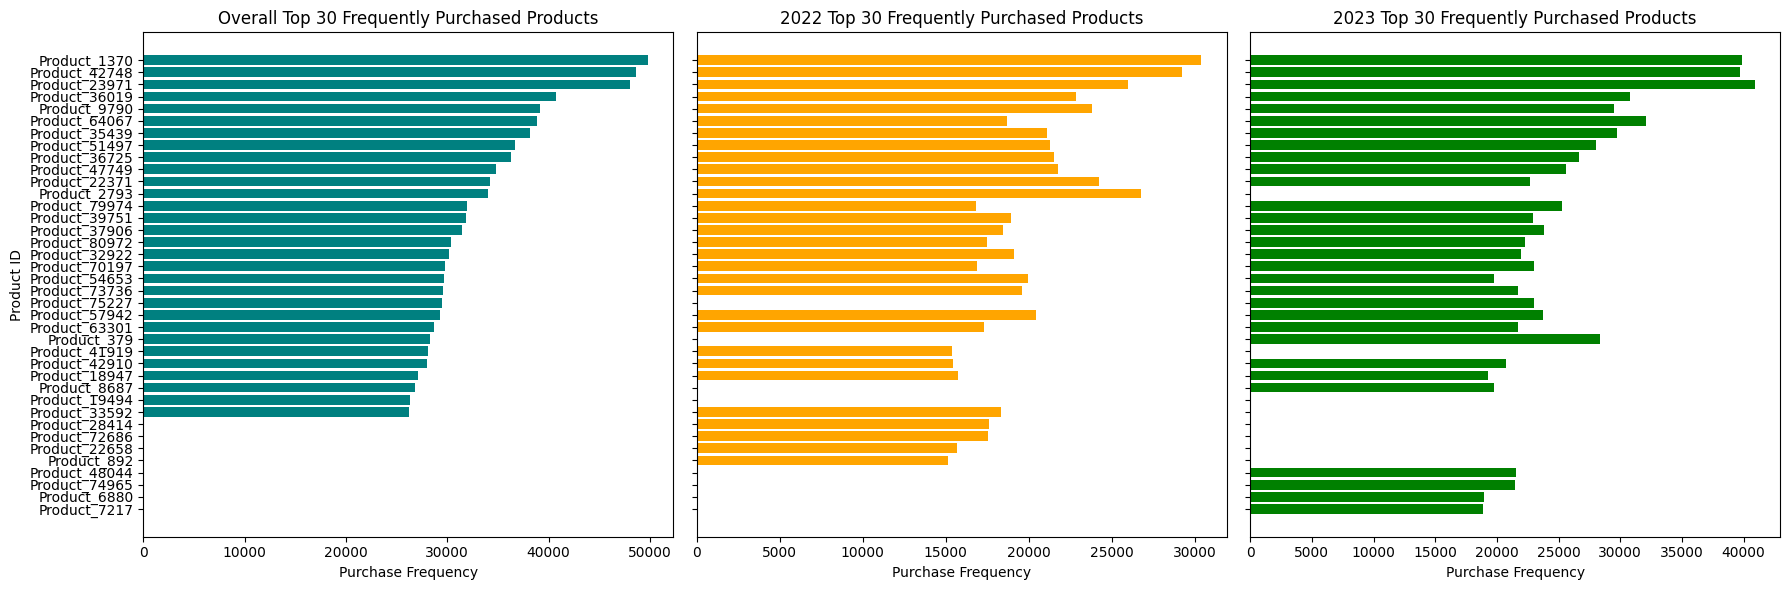

In [6]:
# Calculate the frequency of purchases for each product
product_purchase_frequency = train_data.groupby('product_id')['customer_id'].nunique().reset_index(name='frequency')
data_2022_frequency = data_2022.groupby('product_id')['customer_id'].nunique().reset_index(name='frequency')
data_2023_frequency = data_2023.groupby('product_id')['customer_id'].nunique().reset_index(name='frequency')

# Sort products based on frequency (in descending order)
product_purchase_frequency = product_purchase_frequency.sort_values(by='frequency', ascending=False)
data_2022_frequency = data_2022_frequency.sort_values(by='frequency', ascending=False)
data_2023_frequency = data_2023_frequency.sort_values(by='frequency', ascending=False)

# Top 50 most frequently purchased products
top_50_frequent_products = product_purchase_frequency.head(50)
data_2022_frequency = data_2022_frequency.head(50)
data_2023_frequency = data_2023_frequency.head(50)

# Create subplots for overall, 2022, and 2023 top 50 frequently purchased products
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Overall top 50 frequently purchased products
axes[0].barh(top_50_frequent_products['product_id'].astype(str), 
             top_50_frequent_products['frequency'], color='teal')
axes[0].set_title('Overall Top 30 Frequently Purchased Products')
axes[0].set_xlabel('Purchase Frequency')
axes[0].set_ylabel('Product ID')
axes[0].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
# Get the top 50 product IDs for each year
top_50_2022_products = set(data_2022_frequency['product_id'].head(50))
top_50_2023_products = set(data_2023_frequency['product_id'].head(50))
top_50_products =set(product_purchase_frequency['product_id'].head(50))

# Find products common to 2024 and other years
common_products_2022_2023 = top_50_2022_products.intersection(top_50_2023_products)
common_products_all_years = common_products_2022_2023.intersection(top_50_products)

print(common_products_all_years)

{'Product_42748', 'Product_32922', 'Product_1370', 'Product_35439', 'Product_79974', 'Product_57942', 'Product_51497', 'Product_70197', 'Product_63301', 'Product_18947', 'Product_37906', 'Product_23971', 'Product_9790', 'Product_36725', 'Product_22371', 'Product_47749', 'Product_80972', 'Product_73736', 'Product_42910', 'Product_39751', 'Product_64067', 'Product_36019', 'Product_54653'}


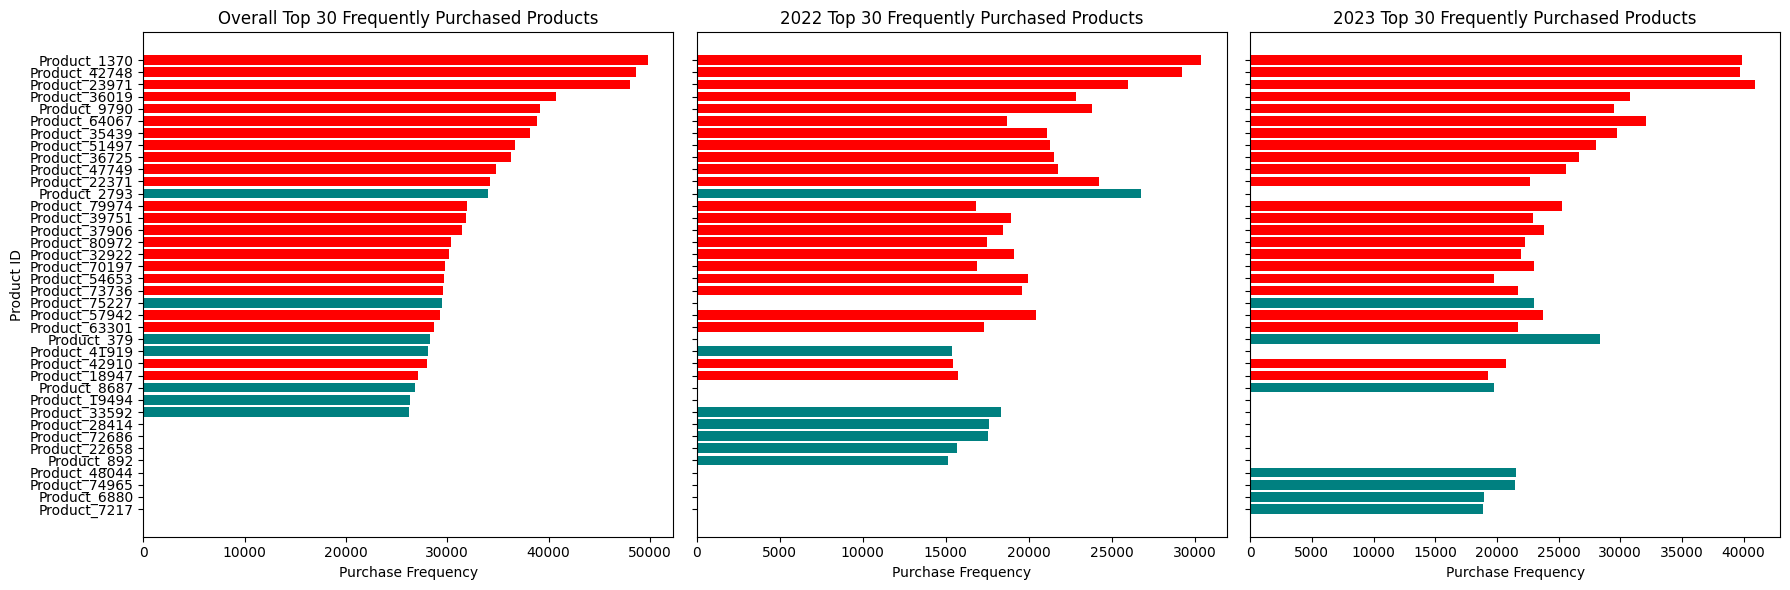

In [9]:
# Create subplots for overall, 2022, and 2023 top 50 frequently purchased products
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Function to highlight common products
def highlight_common_products(products, common_products, color_default='teal', color_highlight='red'):
    return [color_highlight if product in common_products else color_default for product in products]

# Overall top 50 frequently purchased products
product_colors_overall = highlight_common_products(top_50_frequent_products['product_id'].astype(str), 
                                                   common_products_all_years)
axes[0].barh(top_50_frequent_products['product_id'].astype(str), 
             top_50_frequent_products['frequency'], color=product_colors_overall)
axes[0].set_title('Overall Top 30 Frequently Purchased Products')
axes[0].set_xlabel('Purchase Frequency')
axes[0].set_ylabel('Product ID')
axes[0].invert_yaxis()

# Top 50 for 2022
product_colors_2022 = highlight_common_products(data_2022_frequency['product_id'].astype(str), 
                                                common_products_all_years)
axes[1].barh(data_2022_frequency['product_id'].astype(str), 
             data_2022_frequency['frequency'], color=product_colors_2022)
axes[1].set_title('2022 Top 30 Frequently Purchased Products')
axes[1].set_xlabel('Purchase Frequency')
axes[1].invert_yaxis()

# Top 50 for 2023
product_colors_2023 = highlight_common_products(data_2023_frequency['product_id'].astype(str), 
                                                common_products_all_years)
axes[2].barh(data_2023_frequency['product_id'].astype(str), 
             data_2023_frequency['frequency'], color=product_colors_2023)
axes[2].set_title('2023 Top 30 Frequently Purchased Products')
axes[2].set_xlabel('Purchase Frequency')
axes[2].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

## Top popular items

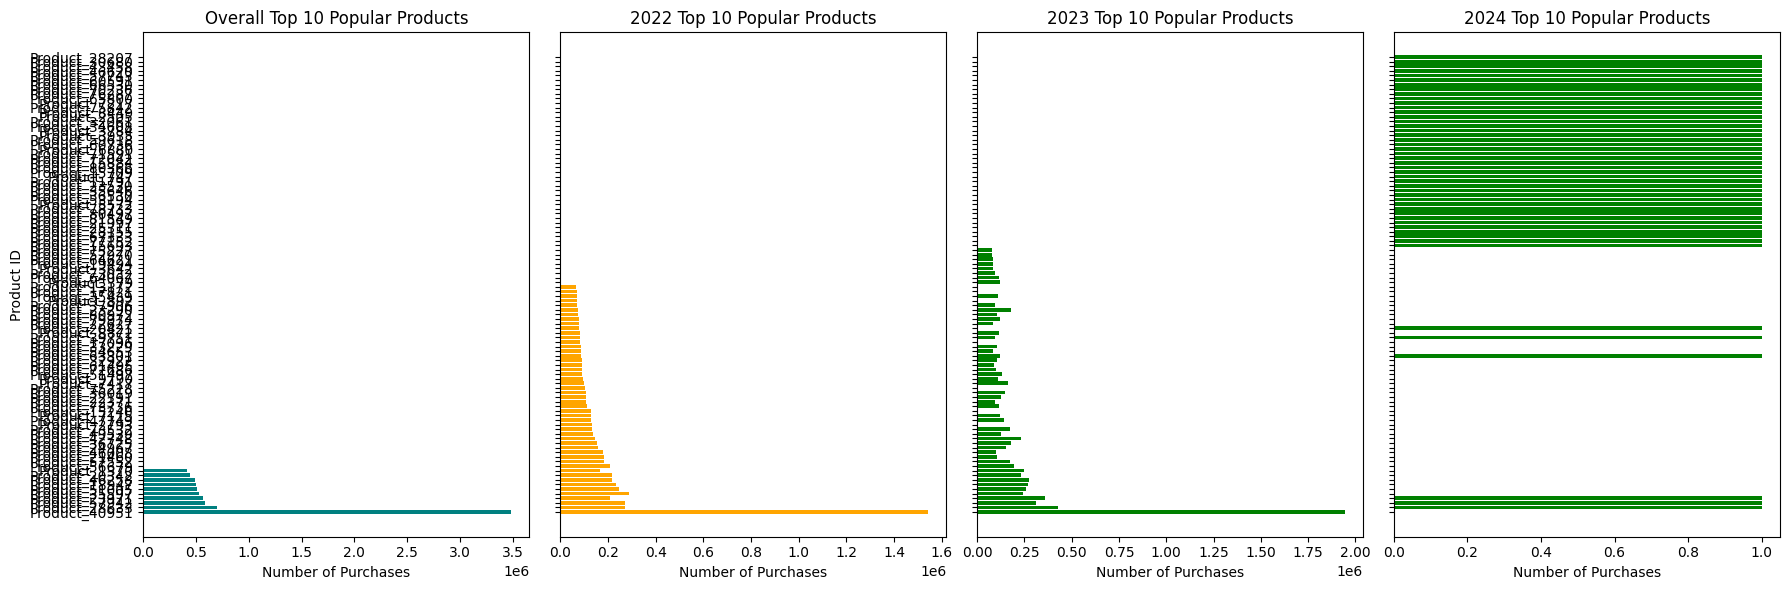

In [12]:
# Calculate the number of times each product was purchased
product_purchase_counts = train_data.groupby('product_id')['quantity'].sum().reset_index()
data_2022_counts = data_2022.groupby('product_id')['quantity'].sum().reset_index()
data_2023_counts = data_2023.groupby('product_id')['quantity'].sum().reset_index()
data_2024_counts = (
    test_data.groupby(["customer_id", "product_id"])["transaction_id"]
    .count()
    .reset_index()
    .rename(columns={"transaction_id": "quantity"})
)

# Sort products based on the number of purchases (in descending order)
product_purchase_counts = product_purchase_counts.sort_values(by='quantity', ascending=False)
data_2022_counts = data_2022_counts.sort_values(by='quantity', ascending=False)
data_2023_counts = data_2023_counts.sort_values(by='quantity', ascending=False)
data_2024_counts = data_2024_counts.sort_values(by='quantity', ascending=False)

# Top 10 most popular products
top_10_popular_products = product_purchase_counts.head(10)
data_2022_counts = data_2022_counts.head(50)
data_2023_counts = data_2023_counts.head(50)
data_2024_counts = data_2024_counts.head(50)

# Create subplots for overall, 2022, and 2023 top 10 popular products
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

# Overall top 10 popular products
axes[0].barh(top_10_popular_products['product_id'].astype(str), 
             top_10_popular_products['quantity'], color='teal')
axes[0].set_title('Overall Top 10 Popular Products')
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Product ID')
axes[0].invert_yaxis()

# Top 10 for 2022
axes[1].barh(data_2022_counts['product_id'].astype(str), 
             data_2022_counts['quantity'], color='orange')
axes[1].set_title('2022 Top 10 Popular Products')
axes[1].set_xlabel('Number of Purchases')
axes[1].invert_yaxis()

# Top 10 for 2023
axes[2].barh(data_2023_counts['product_id'].astype(str), 
             data_2023_counts['quantity'], color='green')
axes[2].set_title('2023 Top 10 Popular Products')
axes[2].set_xlabel('Number of Purchases')
axes[2].invert_yaxis()

# Top 10 for 2024
axes[3].barh(data_2024_counts['product_id'].astype(str), 
             data_2024_counts['quantity'], color='green')
axes[3].set_title('2024 Top 10 Popular Products')
axes[3].set_xlabel('Number of Purchases')
axes[3].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
# Get the top 50 product IDs for each year
top_50_2022_products = set(data_2022_counts['product_id'].head(50))
top_50_2023_products = set(data_2023_counts['product_id'].head(50))
top_50_2024_products = set(data_2024_counts['product_id'].head(50))
top_50_products =set(product_purchase_counts['product_id'].head(50))

# Find products common to 2024 and other years
common_products_2024_2023 = top_50_2024_products.intersection(top_50_2023_products)
common_products_2024_2022 = top_50_2024_products.intersection(top_50_2022_products)
common_products_2024_all = top_50_2024_products.intersection(top_50_products)
common_products_2022_2023_2024 = common_products_2024_2023.union(common_products_2024_2022)
common_products_all_years = common_products_2022_2023_2024.union(common_products_2024_all)

print(common_products_all_years)

{'Product_23971', 'Product_28633', 'Product_39751', 'Product_20421', 'Product_63301', 'Product_57942'}


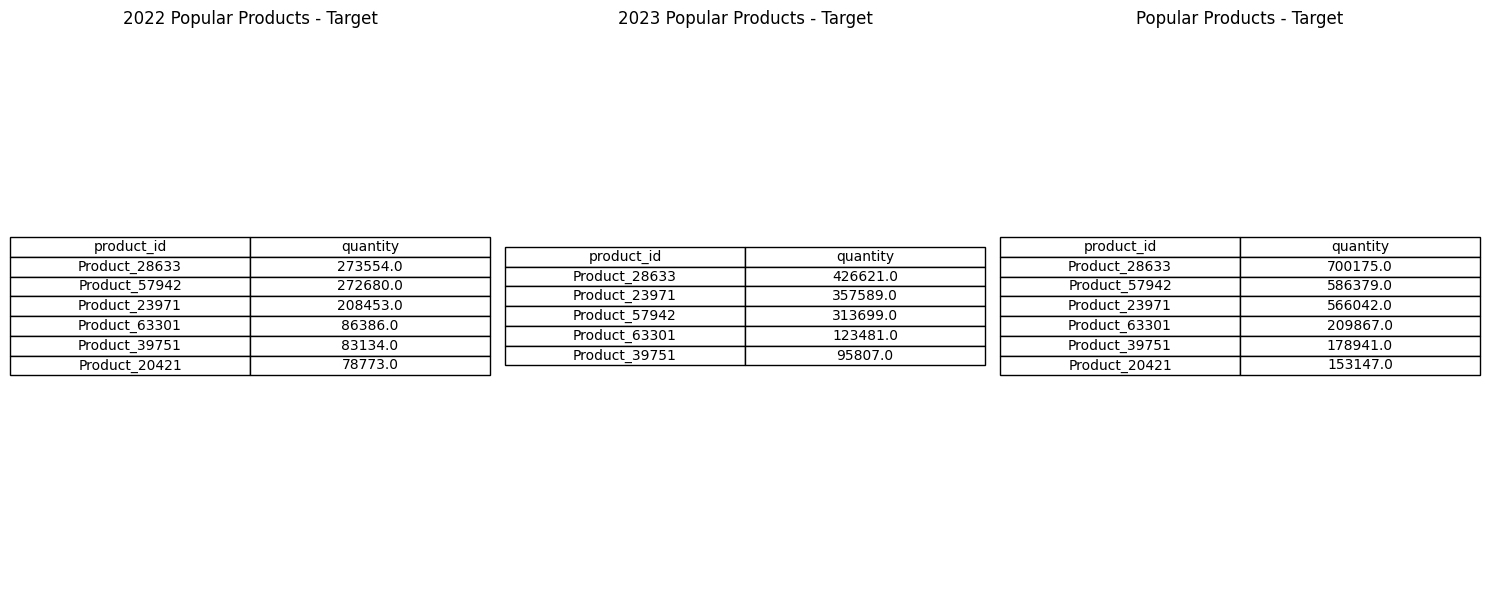

In [16]:
# Define the target products
target_products = {'Product_23971', 'Product_28633', 'Product_39751', 'Product_20421', 'Product_63301', 'Product_57942'}

# Filter each year's data to only include the target products
target_2022 = data_2022_counts[data_2022_counts['product_id'].isin(target_products)]
target_2023 = data_2023_counts[data_2023_counts['product_id'].isin(target_products)]
target = product_purchase_counts[product_purchase_counts['product_id'].isin(target_products)]

# Visualize using tables
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# 2022 Table
axes[0].axis('off')
axes[0].set_title("2022 Popular Products - Target")
axes[0].table(cellText=target_2022.values,
              colLabels=target_2022.columns,
              cellLoc='center', loc='center')

# 2023 Table
axes[1].axis('off')
axes[1].set_title("2023 Popular Products - Target")
axes[1].table(cellText=target_2023.values,
              colLabels=target_2023.columns,
              cellLoc='center', loc='center')

# 2024 Table
axes[2].axis('off')
axes[2].set_title("Popular Products - Target")
axes[2].table(cellText=target.values,
              colLabels=target.columns,
              cellLoc='center', loc='center')

# Adjust layout
plt.tight_layout()
plt.show()

In [42]:
print(test_data[test_data['product_id']=='Product_40951'].sort_values(by='customer_id'))

                transaction_id      customer_id     product_id
458382  Transaction_2024_40944  Household_10006  Product_40951
79006   Transaction_2024_19608  Household_10013  Product_40951
68470   Transaction_2024_16970  Household_10015  Product_40951
458459  Transaction_2024_55259  Household_10021  Product_40951
458470  Transaction_2024_37630  Household_10022  Product_40951
...                        ...              ...            ...
864358  Transaction_2024_29037   Household_9971  Product_40951
458289  Transaction_2024_57725   Household_9984  Product_40951
458318  Transaction_2024_48545   Household_9992  Product_40951
458327  Transaction_2024_28743   Household_9994  Product_40951
864469  Transaction_2024_13344   Household_9997  Product_40951

[5712 rows x 3 columns]


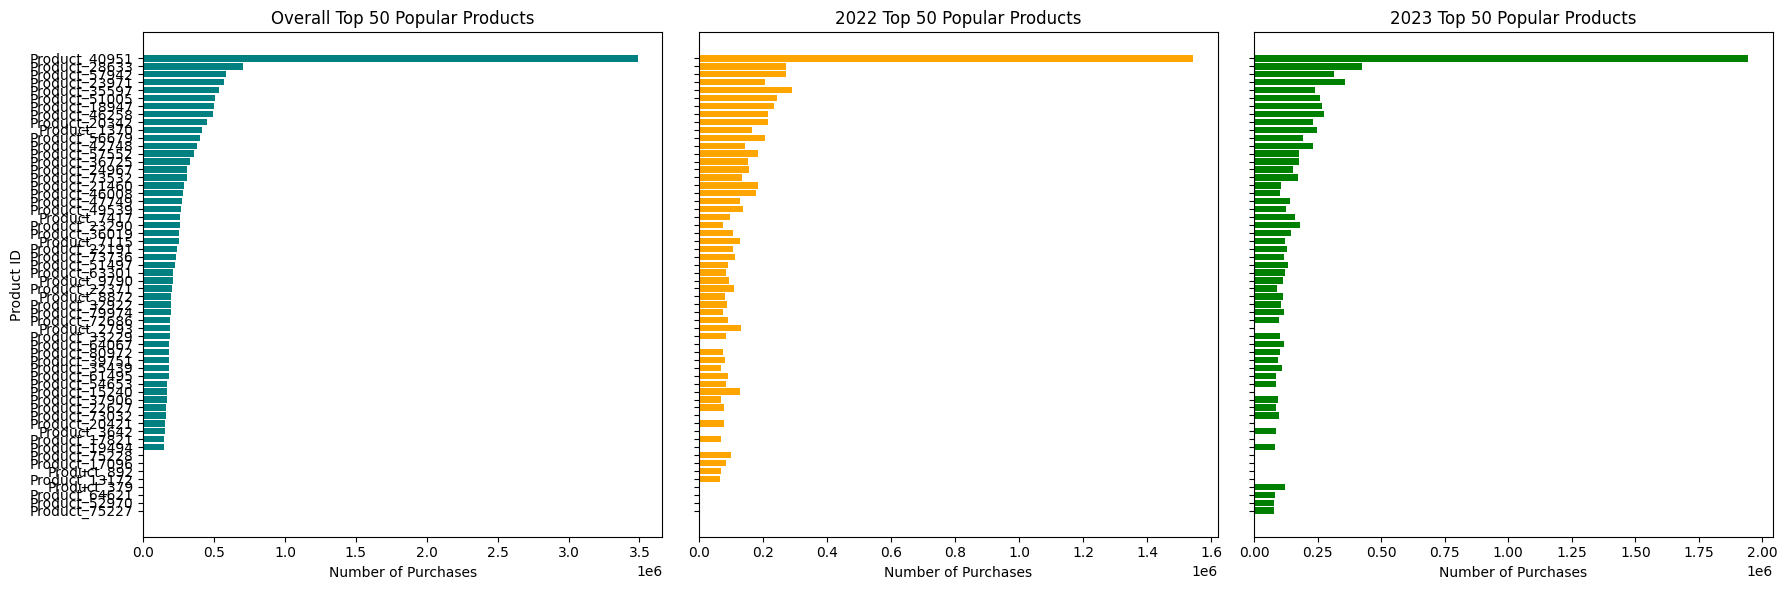

In [33]:
# Calculate the number of times each product was purchased
product_purchase_counts = train_data.groupby('product_id')['quantity'].sum().reset_index()
data_2022_counts = data_2022.groupby('product_id')['quantity'].sum().reset_index()
data_2023_counts = data_2023.groupby('product_id')['quantity'].sum().reset_index()

# Sort products based on the number of purchases (in descending order)
product_purchase_counts = product_purchase_counts.sort_values(by='quantity', ascending=False)
data_2022_counts = data_2022_counts.sort_values(by='quantity', ascending=False)
data_2023_counts = data_2023_counts.sort_values(by='quantity', ascending=False)

# Top 10 most popular products
top_10_popular_products = product_purchase_counts.head(50)
data_2022_counts = data_2022_counts.head(50)
data_2023_counts = data_2023_counts.head(50)

# Create subplots for overall, 2022, and 2023 top 10 popular products
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Overall top 10 popular products
axes[0].barh(top_10_popular_products['product_id'].astype(str), 
             top_10_popular_products['quantity'], color='teal')
axes[0].set_title('Overall Top 50 Popular Products')
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Product ID')
axes[0].invert_yaxis()

# Top 10 for 2022
axes[1].barh(data_2022_counts['product_id'].astype(str), 
             data_2022_counts['quantity'], color='orange')
axes[1].set_title('2022 Top 50 Popular Products')
axes[1].set_xlabel('Number of Purchases')
axes[1].invert_yaxis()

# Top 10 for 2023
axes[2].barh(data_2023_counts['product_id'].astype(str), 
             data_2023_counts['quantity'], color='green')
axes[2].set_title('2023 Top 50 Popular Products')
axes[2].set_xlabel('Number of Purchases')
axes[2].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

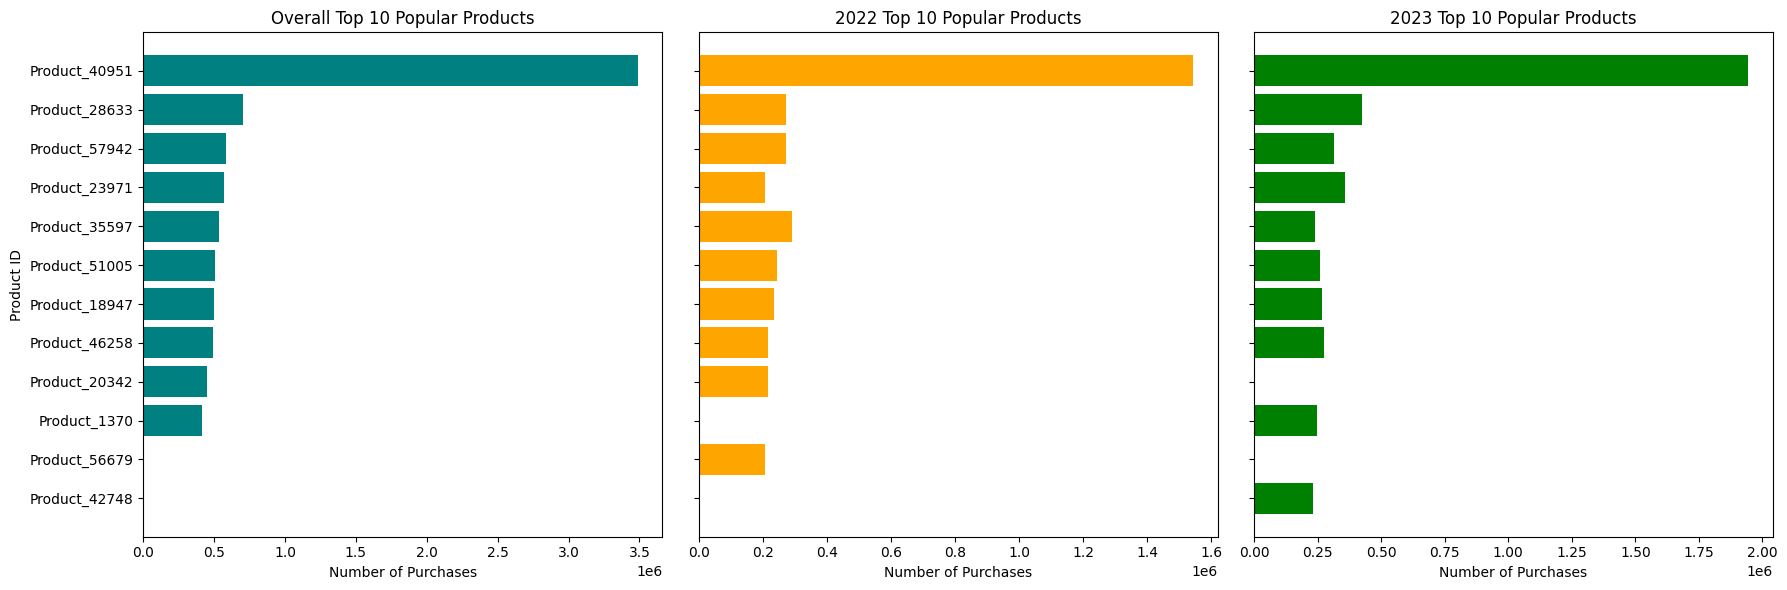

In [5]:
# Calculate the number of times each product was purchased
product_purchase_counts = train_data.groupby('product_id')['quantity'].sum().reset_index()
data_2022_counts = data_2022.groupby('product_id')['quantity'].sum().reset_index()
data_2023_counts = data_2023.groupby('product_id')['quantity'].sum().reset_index()

# Sort products based on the number of purchases (in descending order)
product_purchase_counts = product_purchase_counts.sort_values(by='quantity', ascending=False)
data_2022_counts = data_2022_counts.sort_values(by='quantity', ascending=False)
data_2023_counts = data_2023_counts.sort_values(by='quantity', ascending=False)

# Top 10 most popular products
top_10_popular_products = product_purchase_counts.head(10)
data_2022_counts = data_2022_counts.head(10)
data_2023_counts = data_2023_counts.head(10)

# Create subplots for overall, 2022, and 2023 top 10 popular products
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Overall top 10 popular products
axes[0].barh(top_10_popular_products['product_id'].astype(str), 
             top_10_popular_products['quantity'], color='teal')
axes[0].set_title('Overall Top 10 Popular Products')
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Product ID')
axes[0].invert_yaxis()

# Top 10 for 2022
axes[1].barh(data_2022_counts['product_id'].astype(str), 
             data_2022_counts['quantity'], color='orange')
axes[1].set_title('2022 Top 10 Popular Products')
axes[1].set_xlabel('Number of Purchases')
axes[1].invert_yaxis()

# Top 10 for 2023
axes[2].barh(data_2023_counts['product_id'].astype(str), 
             data_2023_counts['quantity'], color='green')
axes[2].set_title('2023 Top 10 Popular Products')
axes[2].set_xlabel('Number of Purchases')
axes[2].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
# Get all unique customers from true_data (assuming true_data contains customer information)
unique_customers = test_data['customer_id'].unique()

# Create a DataFrame where each customer has the same top 10 products
top_10_recommendations = pd.DataFrame({
    'customer_id': np.repeat(unique_customers, 10),
    'product_id': np.tile(top_10_popular_products['product_id'], len(unique_customers)),
    'rank': np.tile(range(1, 11), len(unique_customers))  # rank from 1 to 10
})

# Calculate hitrate@10
hitrate = hitrate_at_k(test_data, top_10_recommendations, k=10)
print(f'Hitrate@10: {hitrate}')

Hitrate@10: 0.04524044146825398


In [7]:
# Get all unique customers from true_data (assuming true_data contains customer information)
unique_customers = test_data['customer_id'].unique()

# Create a DataFrame where each customer has the same top 10 products
top_10_recommendations = pd.DataFrame({
    'customer_id': np.repeat(unique_customers, 10),
    'product_id': np.tile(data_2022_counts['product_id'], len(unique_customers)),
    'rank': np.tile(range(1, 11), len(unique_customers))  # rank from 1 to 10
})

# Calculate hitrate@10
hitrate = hitrate_at_k(test_data, top_10_recommendations, k=10)
print(f'Hitrate@10: {hitrate}')

Hitrate@10: 0.038742628968253964


In [8]:
# Get all unique customers from true_data (assuming true_data contains customer information)
unique_customers = test_data['customer_id'].unique()

# Create a DataFrame where each customer has the same top 10 products
top_10_recommendations = pd.DataFrame({
    'customer_id': np.repeat(unique_customers, 10),
    'product_id': np.tile(data_2023_counts['product_id'], len(unique_customers)),
    'rank': np.tile(range(1, 11), len(unique_customers))  # rank from 1 to 10
})

# Calculate hitrate@10
hitrate = hitrate_at_k(test_data, top_10_recommendations, k=10)
print(f'Hitrate@10: {hitrate}')

Hitrate@10: 0.05609499999999999


## Items purchased per customer

In [9]:
# Group by customer_id and count the number of unique products they bought
unique_items_per_customer = train_data.groupby('customer_id')['product_id'].nunique().reset_index()
unique_items_per_customer_2022 = data_2022.groupby('customer_id')['product_id'].nunique().reset_index()
unique_items_per_customer_2023 = data_2023.groupby('customer_id')['product_id'].nunique().reset_index()

# Rename the column to make it more descriptive
unique_items_per_customer = unique_items_per_customer.rename(columns={'product_id': 'unique_items_bought'})
unique_items_per_customer = unique_items_per_customer.sort_values(by='unique_items_bought', ascending=False)

unique_items_per_customer_2022 = unique_items_per_customer_2022.rename(columns={'product_id': 'unique_items_bought'})
unique_items_per_customer_2022 = unique_items_per_customer_2022.sort_values(by='unique_items_bought', ascending=False)

unique_items_per_customer_2023 = unique_items_per_customer_2023.rename(columns={'product_id': 'unique_items_bought'})
unique_items_per_customer_2023 = unique_items_per_customer_2023.sort_values(by='unique_items_bought', ascending=False)

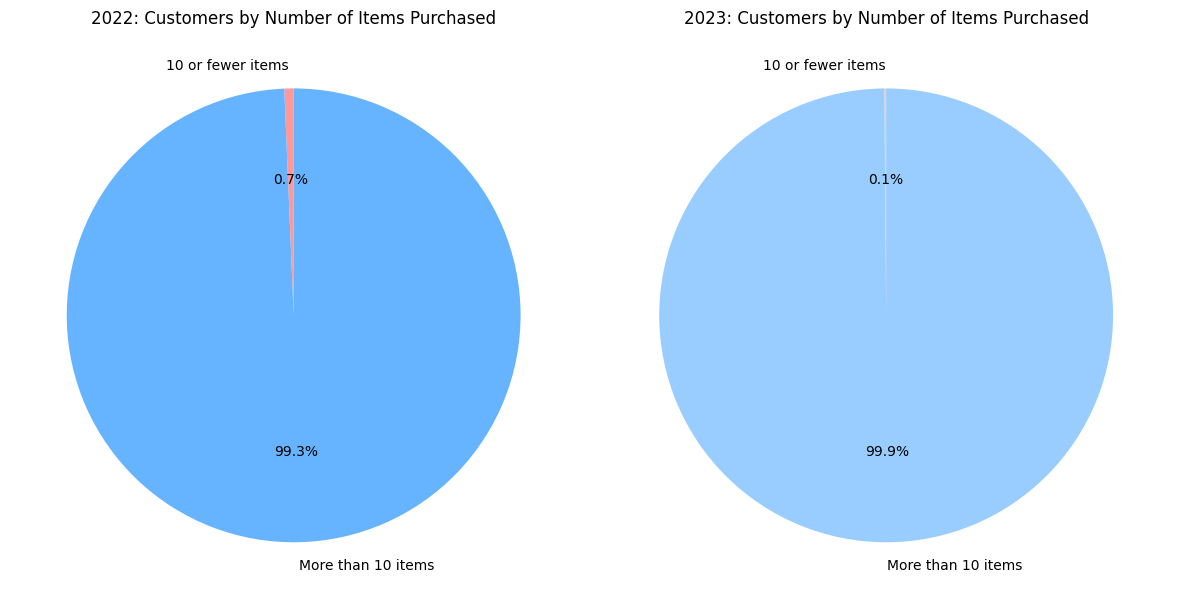

In [10]:
# Filter customers who bought 10 items or fewer
customers_with_10_or_less_2022 = unique_items_per_customer_2022[unique_items_per_customer_2022['unique_items_bought'] <= 10]
customers_with_10_or_less_2023 = unique_items_per_customer_2023[unique_items_per_customer_2023['unique_items_bought'] <= 10]

# Calculate the number of customers who bought 10 or fewer items
num_customers_with_10_or_less_2022 = len(customers_with_10_or_less_2022)
num_customers_with_10_or_less_2023 = len(customers_with_10_or_less_2023)

# Calculate the total number of customers
total_customers_2022 = len(unique_items_per_customer_2022)
total_customers_2023 = len(unique_items_per_customer_2023)

# Calculate the percentage of customers who bought 10 or fewer items
percentage_customers_with_10_or_less_2022 = (num_customers_with_10_or_less_2022 / total_customers_2022) * 100
percentage_customers_more_than_10_2022 = 100 - percentage_customers_with_10_or_less_2022
percentage_customers_with_10_or_less_2023 = (num_customers_with_10_or_less_2023 / total_customers_2023) * 100
percentage_customers_more_than_10_2023 = 100 - percentage_customers_with_10_or_less_2023

# Data for 2022
labels_2022 = ['10 or fewer items', 'More than 10 items']
sizes_2022 = [percentage_customers_with_10_or_less_2022, percentage_customers_more_than_10_2022]
colors_2022 = ['#ff9999', '#66b3ff']

# Data for 2023
labels_2023 = ['10 or fewer items', 'More than 10 items']
sizes_2023 = [percentage_customers_with_10_or_less_2023, percentage_customers_more_than_10_2023]
colors_2023 = ['#ffcc99', '#99ccff']

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for 2022
axes[0].pie(sizes_2022, labels=labels_2022, autopct='%1.1f%%', startangle=90, colors=colors_2022)
axes[0].set_title('2022: Customers by Number of Items Purchased')

# Pie chart for 2023
axes[1].pie(sizes_2023, labels=labels_2023, autopct='%1.1f%%', startangle=90, colors=colors_2023)
axes[1].set_title('2023: Customers by Number of Items Purchased')

# Equal aspect ratio ensures that the pie charts are drawn as circles
plt.tight_layout()
plt.show()

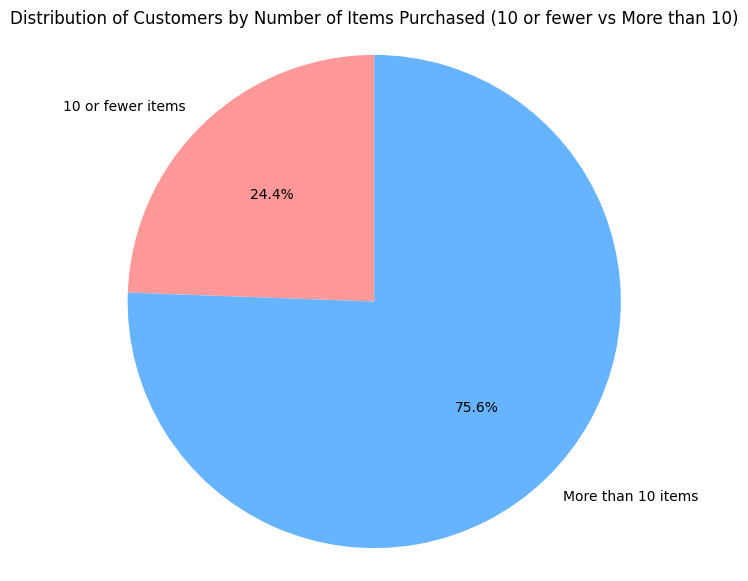

In [11]:
unique_items_per_customer_2024 = test_data.groupby('customer_id')['product_id'].nunique().reset_index()

unique_items_per_customer_2024 = unique_items_per_customer_2024.rename(columns={'product_id': 'unique_items_bought'})
unique_items_per_customer_2024 = unique_items_per_customer_2024.sort_values(by='unique_items_bought', ascending=False)

# Filter customers who bought 10 items or fewer
customers_with_10_or_less_2024 = unique_items_per_customer_2024[unique_items_per_customer_2024['unique_items_bought'] <= 10]

# Calculate the number of customers who bought 10 or fewer items
num_customers_with_10_or_less_2024 = len(customers_with_10_or_less_2024)

# Calculate the total number of customers
total_customers_2024 = len(unique_items_per_customer_2024)

# Calculate the percentage of customers who bought 10 or fewer items
percentage_customers_with_10_or_less_2024 = (num_customers_with_10_or_less_2024 / total_customers_2024) * 100
percentage_customers_more_than_10_2024 = 100 - percentage_customers_with_10_or_less_2024

# Data for the pie chart
labels = ['10 or fewer items', 'More than 10 items']
sizes = [percentage_customers_with_10_or_less_2024, percentage_customers_more_than_10_2024]
colors = ['#ff9999','#66b3ff']  # Colors for the pie chart

# Plotting the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Customers by Number of Items Purchased (10 or fewer vs More than 10)')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

In [12]:
# Group by customer_id and product_id to calculate the total quantity purchased by each customer for each product
customer_product_purchase_counts = train_data.groupby(['customer_id', 'product_id'])['quantity'].sum().reset_index()

# Sort the products for each customer based on the quantity purchased (in descending order)
customer_product_purchase_counts_sorted = customer_product_purchase_counts.sort_values(by=['customer_id', 'quantity'], ascending=[True, False])

# Get the top 10 most purchased products for each customer
top_10_per_customer = customer_product_purchase_counts_sorted.groupby('customer_id').head(10)

# Assign rank (1 to 10) to the top 10 products for each customer
top_10_per_customer['rank'] = top_10_per_customer.groupby('customer_id').cumcount() + 1

# Now 'rank' column will have ranks from 1 to 10 for each customer, and 'quantity' is retained as the total quantity purchased
top_10_recommendations = top_10_per_customer[['customer_id', 'product_id', 'rank']]  # Select only customer_id, product_id, and rank columns

# Calculate hitrate@10
hitrate = hitrate_at_k(test_data, top_10_recommendations, k=10)
print(f'Hitrate@10: {hitrate}')

/tmp/ipykernel_30/3261425722.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_per_customer['rank'] = top_10_per_customer.groupby('customer_id').cumcount() + 1


Hitrate@10: 0.2987870535714286


In [13]:
# Group by customer_id and product_id to calculate the total quantity purchased by each customer for each product
customer_product_purchase_counts = data_2022.groupby(['customer_id', 'product_id'])['quantity'].sum().reset_index()

# Sort the products for each customer based on the quantity purchased (in descending order)
customer_product_purchase_counts_sorted = customer_product_purchase_counts.sort_values(by=['customer_id', 'quantity'], ascending=[True, False])

# Get the top 10 most purchased products for each customer
top_10_per_customer = customer_product_purchase_counts_sorted.groupby('customer_id').head(10)

# Assign rank (1 to 10) to the top 10 products for each customer
top_10_per_customer['rank'] = top_10_per_customer.groupby('customer_id').cumcount() + 1

# Now 'rank' column will have ranks from 1 to 10 for each customer, and 'quantity' is retained as the total quantity purchased
top_10_recommendations = top_10_per_customer[['customer_id', 'product_id', 'rank']]  # Select only customer_id, product_id, and rank columns

# Calculate hitrate@10
hitrate = hitrate_at_k(test_data, top_10_recommendations, k=10)
print(f'Hitrate@10: {hitrate}')

/tmp/ipykernel_30/1608294808.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_per_customer['rank'] = top_10_per_customer.groupby('customer_id').cumcount() + 1


Hitrate@10: 0.1678663988095238


In [14]:
# Group by customer_id and product_id to calculate the total quantity purchased by each customer for each product
customer_product_purchase_counts = data_2023.groupby(['customer_id', 'product_id'])['quantity'].sum().reset_index()

# Sort the products for each customer based on the quantity purchased (in descending order)
customer_product_purchase_counts_sorted = customer_product_purchase_counts.sort_values(by=['customer_id', 'quantity'], ascending=[True, False])

# Get the top 10 most purchased products for each customer
top_10_per_customer = customer_product_purchase_counts_sorted.groupby('customer_id').head(10)

# Assign rank (1 to 10) to the top 10 products for each customer
top_10_per_customer['rank'] = top_10_per_customer.groupby('customer_id').cumcount() + 1

# Now 'rank' column will have ranks from 1 to 10 for each customer, and 'quantity' is retained as the total quantity purchased
top_10_recommendations = top_10_per_customer[['customer_id', 'product_id', 'rank']]  # Select only customer_id, product_id, and rank columns

# Calculate hitrate@10
hitrate = hitrate_at_k(test_data, top_10_recommendations, k=10)
print(f'Hitrate@10: {hitrate}')

/tmp/ipykernel_30/3694776019.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_per_customer['rank'] = top_10_per_customer.groupby('customer_id').cumcount() + 1


Hitrate@10: 0.3123588888888889


## Top most purchased recently products

In [5]:
# Group by customer_id and product_id to calculate quantity and most recent purchase
customer_product_data = train_data.groupby(['customer_id', 'product_id']).agg({
    'quantity': 'sum',
    'recency': 'min'  # Minimum days since purchase (most recent)
}).reset_index()

# Normalize quantity and recency scores
customer_product_data['quantity_score'] = customer_product_data['quantity'] / customer_product_data['quantity'].max()
customer_product_data['recency_score'] = 1 - (customer_product_data['recency'] / customer_product_data['recency'].max())  # Recent = higher score

# Merge frequency data into customer_product_data
frequency = train_data.groupby(['customer_id', 'product_id'])['transaction_id'].count().reset_index(name='frequency')
customer_product_data = customer_product_data.merge(frequency, on=['customer_id', 'product_id'], how='left')

# Fill any missing frequency values (if any product has no transactions counted, assume 0)
customer_product_data['frequency'] = customer_product_data['frequency'].fillna(0)

# Normalize frequency score
customer_product_data['frequency_score'] = customer_product_data['frequency'] / customer_product_data['frequency'].max()

Best alpha value: 0.9 with score: 0.33633268353174606


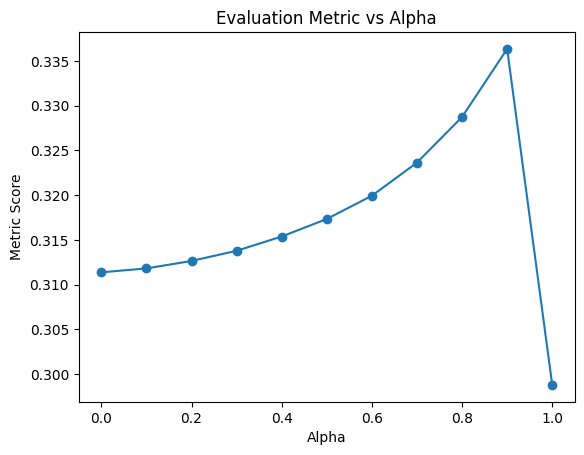

In [16]:
alpha_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_alpha = None
best_metric_score = float('-inf')  # Or a large negative value to track best score
metric_scores = []

for alpha in alpha_values:
    # Calculate the final score with this alpha value
    customer_product_data['final_score'] = (
        alpha * customer_product_data['quantity_score'] + 
        (1 - alpha) * customer_product_data['recency_score']
    )

    # Rank products for each customer with unique ranks
    customer_product_data['rank'] = customer_product_data.sort_values(
        by=['customer_id', 'final_score', 'quantity', 'product_id'],  # Add secondary sort keys
        ascending=[True, False, False, True]  # Ensure consistent order
    ).groupby('customer_id').cumcount() + 1  # Assign unique incremental ranks
    
    # Filter only the top 10 items for each customer
    top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]
    
    # Sort by customer_id and rank to ensure proper order
    top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

    # Calculate the evaluation metric hitrate@10
    metric_score = hitrate_at_k(test_data, top_10_recommendations, k=10)
    metric_scores.append(metric_score)
    
    # Track the best alpha and corresponding metric score
    if metric_score > best_metric_score:
        best_metric_score = metric_score
        best_alpha = alpha

print(f"Best alpha value: {best_alpha} with score: {best_metric_score}")

# Plot the results
plt.plot(alpha_values, metric_scores, marker='o')
plt.title("Evaluation Metric vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Metric Score")
plt.show()

Best alpha value: 0.97 with score: 0.34303580357142854


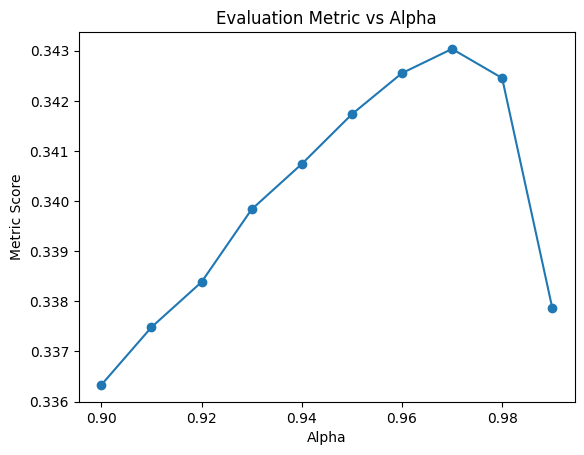

In [17]:
alpha_values = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
best_alpha = None
best_metric_score = float('-inf')  # Or a large negative value to track best score
metric_scores = []

for alpha in alpha_values:
    # Calculate the final score with this alpha value
    customer_product_data['final_score'] = (
        alpha * customer_product_data['quantity_score'] + 
        (1 - alpha) * customer_product_data['recency_score']
    )

    # Rank products for each customer with unique ranks
    customer_product_data['rank'] = customer_product_data.sort_values(
        by=['customer_id', 'final_score', 'quantity', 'product_id'],  # Add secondary sort keys
        ascending=[True, False, False, True]  # Ensure consistent order
    ).groupby('customer_id').cumcount() + 1  # Assign unique incremental ranks
    
    # Filter only the top 10 items for each customer
    top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]
    
    # Sort by customer_id and rank to ensure proper order
    top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

    # Calculate the evaluation metric hitrate@10
    metric_score = hitrate_at_k(test_data, top_10_recommendations, k=10)
    metric_scores.append(metric_score)
    
    # Track the best alpha and corresponding metric score
    if metric_score > best_metric_score:
        best_metric_score = metric_score
        best_alpha = alpha

print(f"Best alpha value: {best_alpha} with score: {best_metric_score}")

# Plot the results
plt.plot(alpha_values, metric_scores, marker='o')
plt.title("Evaluation Metric vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Metric Score")
plt.show()

In [18]:
best_alpha = 0.97

# Calculate the final score with this alpha value
customer_product_data['final_score'] = (
    best_alpha * customer_product_data['quantity_score'] + 
    (1 - best_alpha) * customer_product_data['recency_score']
)

# Rank products for each customer with unique ranks
customer_product_data['rank'] = customer_product_data.sort_values(
    by=['customer_id', 'final_score', 'quantity', 'product_id'],  # Add secondary sort keys
    ascending=[True, False, False, True]  # Ensure consistent order
).groupby('customer_id').cumcount() + 1  # Assign unique incremental ranks

# Filter only the top 10 items for each customer
top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]
    
# Sort by customer_id and rank to ensure proper order
top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

print(f"Best alpha value: {best_alpha} with score: {hitrate_at_k(test_data, top_10_recommendations, k=10)}")

Best alpha value: 0.97 with score: 0.34303580357142854


In [7]:
# Define the set of popular items
popular_items = {'Product_23971', 'Product_28633', 'Product_39751', 'Product_20421', 'Product_63301', 'Product_57942'}

# Add a column to indicate if a product is popular
customer_product_data['is_popular'] = customer_product_data['product_id'].isin(popular_items).astype(int)

final_score_mean=customer_product_data['final_score'].mean()
final_score_min=customer_product_data['final_score'].min()
final_score_max=customer_product_data['final_score'].max()

leverage_values = np.linspace(final_score_min, final_score_max, num=10)

Best_alpha=0.97

Best_score=0
Best_leverage=0
scores=[]

for leverage in leverage_values:
    # Calculate the final score with this alpha value
    customer_product_data['final_score'] = (
        best_alpha * customer_product_data['quantity_score'] + 
        (1 - best_alpha) * customer_product_data['recency_score']
    )
    
    # Rank products for each customer with unique ranks
    customer_product_data['rank'] = customer_product_data.sort_values(
        by=['customer_id', 'final_score', 'quantity', 'product_id'],  # Add secondary sort keys
        ascending=[True, False, False, True]  # Ensure consistent order
    ).groupby('customer_id').cumcount() + 1  # Assign unique incremental ranks

    top_10 = customer_product_data[customer_product_data['rank'] <= 10]
    top_10 = top_10.sort_values(by=['customer_id', 'rank'])
    
    score=hitrate_at_k(test_data, top_10, k=10)
    scores.append(score)

    # Track the best alpha and corresponding metric score
    if score > Best_score:
        Best_score = score
        Best_leverage = leverage

print(f"Best leverage value: {Best_leverage} with score: {Best_score}")

Best leverage value: 0.0022222222222222222 with score: 0.33633268353174606


## Top frequently purchased recently products

Best alpha value: 0.9 with score: 0.35260260416666667


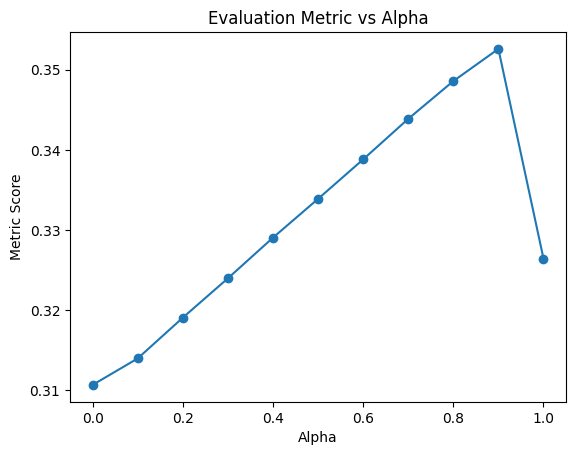

In [6]:
alpha_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_alpha = None
best_metric_score = float('-inf')  # Or a large negative value to track best score
metric_scores = []

for alpha in alpha_values:
    # Calculate the final score with this alpha value
    customer_product_data['final_score'] = (
        alpha * customer_product_data['frequency_score'] + 
        (1 - alpha) * customer_product_data['recency_score']
    )

    # Rank products for each customer with unique ranks
    customer_product_data['rank'] = customer_product_data.sort_values(
        by=['customer_id', 'final_score', 'frequency', 'product_id'],  # Add secondary sort keys
        ascending=[True, False, False, True]  # Ensure consistent order
    ).groupby('customer_id').cumcount() + 1  # Assign unique incremental ranks
    
    # Filter only the top 10 items for each customer
    top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]
    
    # Sort by customer_id and rank to ensure proper order
    top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

    # Calculate the evaluation metric hitrate@10
    metric_score = hitrate_at_k(test_data, top_10_recommendations, k=10)
    metric_scores.append(metric_score)
    
    # Track the best alpha and corresponding metric score
    if metric_score > best_metric_score:
        best_metric_score = metric_score
        best_alpha = alpha

print(f"Best alpha value: {best_alpha} with score: {best_metric_score}")

# Plot the results
plt.plot(alpha_values, metric_scores, marker='o')
plt.title("Evaluation Metric vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Metric Score")
plt.show()

## Top most frequently purchased recently products

In [10]:
# Define the range of alpha values
alpha_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_alpha = None
best_metric_score = float('-inf')  # Track the best metric score
metric_scores = []

for alpha in alpha_values:
    for beta in alpha_values:
        if alpha + beta <= 1:  # Ensure valid weight distribution
            gamma = 1 - alpha - beta
            
            # Calculate the final score using alpha, beta, and gamma
            customer_product_data['final_score'] = (
                alpha * customer_product_data['quantity_score'] + 
                beta * customer_product_data['frequency_score'] +
                gamma * customer_product_data['recency_score']
            )

            # Rank products for each customer with unique ranks
            customer_product_data['rank'] = (
                customer_product_data.sort_values(
                    by=['customer_id', 'final_score', 'quantity', 'product_id'], 
                    ascending=[True, False, False, True]  # Sort order
                ).groupby('customer_id').cumcount() + 1
            )

            # Filter only the top 10 items for each customer
            top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]
            
            # Sort by customer_id and rank to ensure proper order
            top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

            # Calculate the evaluation metric (e.g., hitrate@10)
            metric_score = hitrate_at_k(test_data, top_10_recommendations, k=10)
            metric_scores.append(metric_score)

            # Track the best alpha, beta, and metric score
            if metric_score > best_metric_score:
                best_metric_score = metric_score
                best_alpha = alpha
                best_beta = beta

print(f"Best alpha: {best_alpha}, beta: {best_beta}, gamma: {1 - best_alpha - best_beta} with score: {best_metric_score}")

Best alpha: 0, beta: 0.9, gamma: 0.09999999999999998 with score: 0.3548666815476191


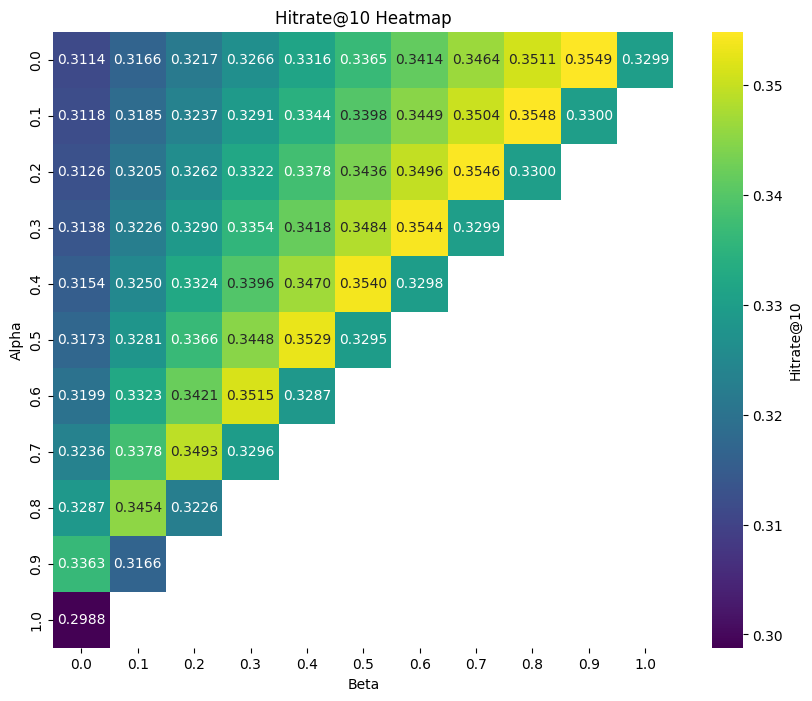

In [20]:
results=[]
k=0
for alpha in alpha_values:
    for beta in alpha_values:
        if alpha + beta <= 1:  # Ensure valid weight distribution
            gamma = 1 - alpha - beta
            results.append((alpha, beta, gamma, metric_scores[k]))
            k+=1

df = pd.DataFrame(results, columns=['alpha', 'beta', 'gamma', 'hitrate@10'])

# Create pivot table for heatmap
heatmap_data = df.pivot(index='alpha', columns='beta', values='hitrate@10')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Hitrate@10'})
plt.title('Hitrate@10 Heatmap')
plt.xlabel('Beta')
plt.ylabel('Alpha')
plt.show()

In [23]:
# Define the range of alpha values
alpha_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
beta_values = [0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8]
best_alpha = None
best_beta = None
best_metric_score = float('-inf')  # Track the best metric score
metric_scores = []

for alpha, beta in zip(alpha_values, beta_values):
    gamma = 0.1
            
    # Calculate the final score using alpha, beta, and gamma
    customer_product_data['final_score'] = (
        alpha * customer_product_data['quantity_score'] + 
        beta * customer_product_data['frequency_score'] +
        gamma * customer_product_data['recency_score']
    )

    # Rank products for each customer with unique ranks
    customer_product_data['rank'] = (
        customer_product_data.sort_values(
            by=['customer_id', 'final_score', 'quantity', 'product_id'], 
            ascending=[True, False, False, True]  # Sort order
        ).groupby('customer_id').cumcount() + 1
    )

    # Filter only the top 10 items for each customer
    top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]
            
    # Sort by customer_id and rank to ensure proper order
    top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

    # Calculate the evaluation metric (e.g., hitrate@10)
    metric_score = hitrate_at_k(test_data, top_10_recommendations, k=10)
    metric_scores.append(metric_score)

    # Track the best alpha, beta, and metric score
    if metric_score > best_metric_score:
        best_metric_score = metric_score
        best_alpha = alpha
        best_beta = beta

print(f"Best alpha: {best_alpha}, beta: {best_beta}, gamma: 0.1 with score: {best_metric_score}")

Best alpha: 0.03, beta: 0.87, gamma: 0.1 with score: 0.3549018601190475


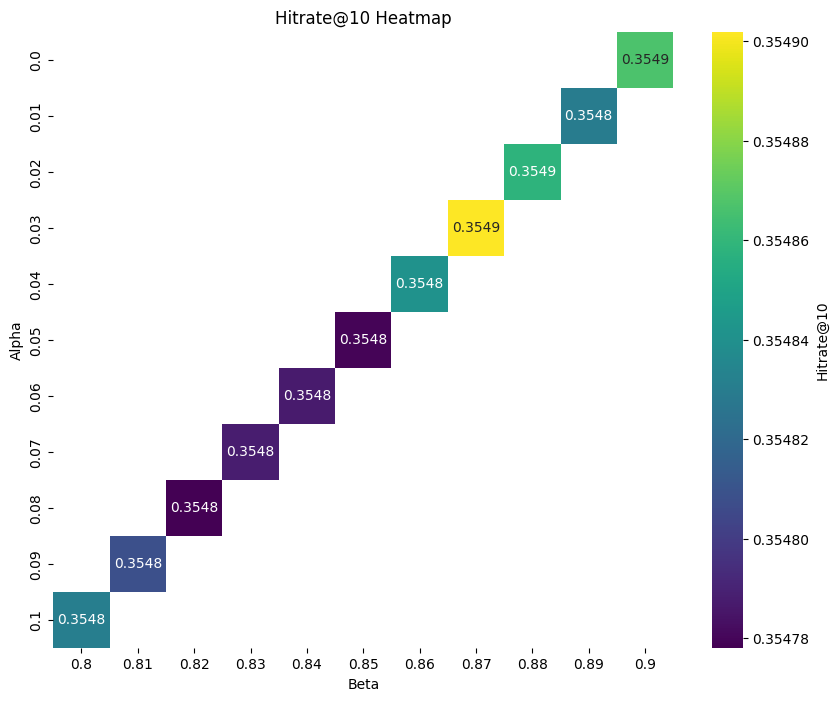

In [25]:
results=[]
k=0
for alpha, beta in zip(alpha_values, beta_values):
    results.append((alpha, beta, metric_scores[k]))
    k+=1

df = pd.DataFrame(results, columns=['alpha', 'beta', 'hitrate@10'])

# Create pivot table for heatmap
heatmap_data = df.pivot(index='alpha', columns='beta', values='hitrate@10')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Hitrate@10'})
plt.title('Hitrate@10 Heatmap')
plt.xlabel('Beta')
plt.ylabel('Alpha')
plt.show()

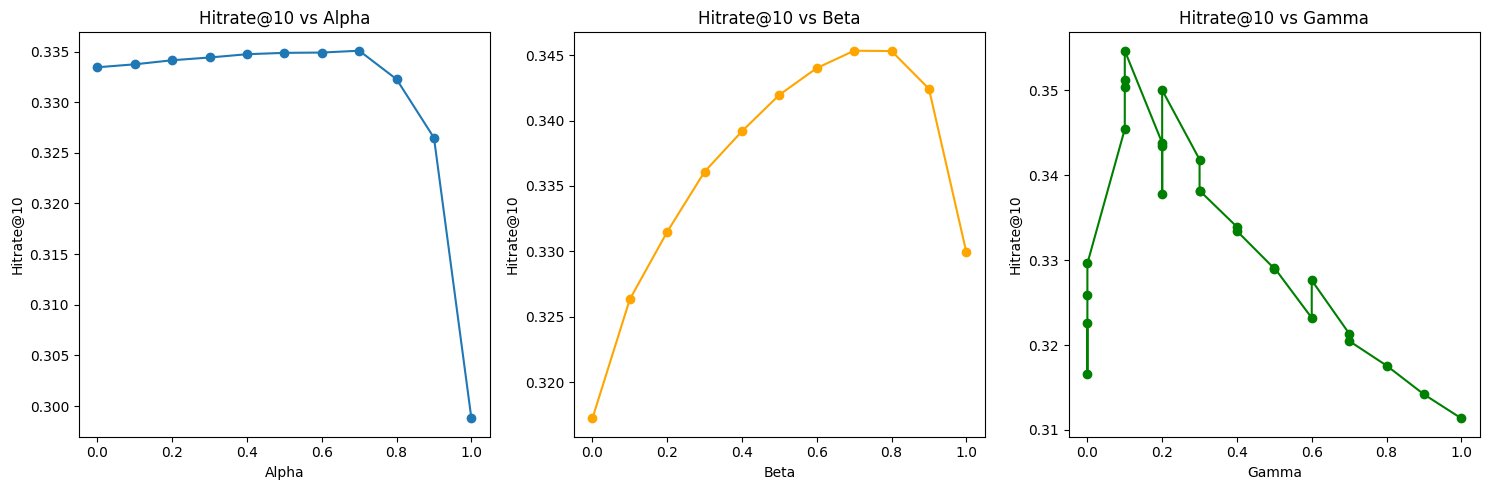

In [21]:
# Extract data for line plots
alpha_plot = df.groupby('alpha')['hitrate@10'].mean()
beta_plot = df.groupby('beta')['hitrate@10'].mean()
gamma_plot = df.groupby('gamma')['hitrate@10'].mean()

# Plot line graphs
plt.figure(figsize=(15, 5))

# Alpha vs Hitrate
plt.subplot(1, 3, 1)
plt.plot(alpha_plot.index, alpha_plot.values, marker='o')
plt.title("Hitrate@10 vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Hitrate@10")

# Beta vs Hitrate
plt.subplot(1, 3, 2)
plt.plot(beta_plot.index, beta_plot.values, marker='o', color='orange')
plt.title("Hitrate@10 vs Beta")
plt.xlabel("Beta")
plt.ylabel("Hitrate@10")

# Gamma vs Hitrate
plt.subplot(1, 3, 3)
plt.plot(gamma_plot.index, gamma_plot.values, marker='o', color='green')
plt.title("Hitrate@10 vs Gamma")
plt.xlabel("Gamma")
plt.ylabel("Hitrate@10")

plt.tight_layout()
plt.show()

In [20]:
Best_alpha=0.03
Best_beta=0.87
Best_gamma=0.1

# Calculate the final score using alpha, beta, and gamma
customer_product_data['final_score'] = (
    Best_alpha * customer_product_data['quantity_score'] + 
    Best_beta * customer_product_data['frequency_score'] +
    Best_gamma * customer_product_data['recency_score']
)

# Rank products for each customer with unique ranks
customer_product_data['rank'] = (
    customer_product_data.sort_values(
        by=['customer_id', 'final_score', 'quantity', 'product_id'], 
        ascending=[True, False, False, True]  # Sort order
    ).groupby('customer_id').cumcount() + 1
)

# Filter only the top 10 items for each customer
top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]
            
# Sort by customer_id and rank to ensure proper order
top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

score=hitrate_at_k(test_data, top_10_recommendations, k=10)
score

0.3549018601190475

In [25]:
# Define the set of popular items
popular_items = {'Product_23971', 'Product_28633', 'Product_39751', 'Product_20421', 'Product_63301', 'Product_57942'}

# Add a column to indicate if a product is popular
customer_product_data['is_popular'] = customer_product_data['product_id'].isin(popular_items).astype(int)

final_score_mean=customer_product_data['final_score'].mean()
final_score_min=customer_product_data['final_score'].min()
final_score_max=customer_product_data['final_score'].max()

leverage_values = np.linspace(final_score_min, final_score_max, num=10)

Best_alpha=0.03
Best_beta=0.87
Best_gamma=0.1

Best_score=0
Best_leverage=0
scores=[]

for leverage in leverage_values:
    customer_product_data['final_score'] = (
        Best_alpha * customer_product_data['quantity_score'] +
        Best_beta * customer_product_data['frequency_score'] +
        Best_gamma * customer_product_data['recency_score'] +
        leverage * customer_product_data['is_popular']
    )
    
    # Rank and filter top 10 items
    customer_product_data['rank'] = (
        customer_product_data.sort_values(
            by=['customer_id', 'final_score', 'quantity', 'product_id'],
            ascending=[True, False, False, True]
        ).groupby('customer_id').cumcount() + 1
    )
    top_10 = customer_product_data[customer_product_data['rank'] <= 10]
    top_10 = top_10.sort_values(by=['customer_id', 'rank'])
    
    score=hitrate_at_k(test_data, top_10, k=10)
    scores.append(score)

    # Track the best alpha and corresponding metric score
    if score > Best_score:
        Best_score = score
        Best_leverage = leverage

print(f"Best leverage value: {Best_leverage} with score: {Best_score}")

Best leverage value: 0.0019395677472984205 with score: 0.3554372023809524


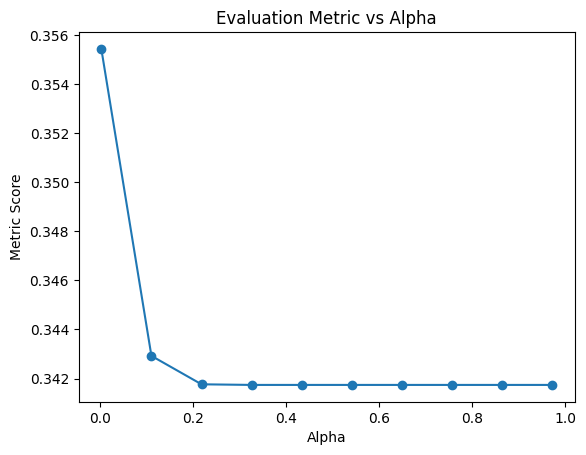

In [26]:
# Plot the results
plt.plot(leverage_values, scores, marker='o')
plt.title("Evaluation Metric vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Metric Score")
plt.show()

In [27]:
# Define the set of popular items
popular_items = {'Product_23971', 'Product_28633', 'Product_39751', 'Product_20421', 'Product_63301', 'Product_57942'}

# Add a column to indicate if a product is popular
customer_product_data['is_popular'] = customer_product_data['product_id'].isin(popular_items).astype(int)

Best_alpha=0.03
Best_beta=0.87
Best_gamma=0.1
Best_leverage=0.0019395677472984205

# Recalculate the final score, adding leverage for popular items
customer_product_data['final_score'] = (
    Best_alpha * customer_product_data['quantity_score'] + 
    Best_beta * customer_product_data['frequency_score'] +
    Best_gamma * customer_product_data['recency_score'] +
    Best_leverage * customer_product_data['is_popular']  # Add leverage
)

# Rank products for each customer with unique ranks
customer_product_data['rank'] = (
    customer_product_data.sort_values(
        by=['customer_id', 'final_score', 'quantity', 'product_id'], 
        ascending=[True, False, False, True]  # Sort order
    ).groupby('customer_id').cumcount() + 1
)

# Filter only the top 10 items for each customer
top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]

# Sort by customer_id and rank to ensure proper order
top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

score=hitrate_at_k(test_data, top_10_recommendations, k=10)
score

0.3554372023809524

## Predictive model

In [8]:
# Define the set of popular items
popular_items = {'Product_23971', 'Product_28633', 'Product_39751', 'Product_20421', 'Product_63301', 'Product_57942'}

# Add a column to indicate if a product is popular
customer_product_data['is_popular'] = customer_product_data['product_id'].isin(popular_items).astype(int)

Best_alpha=0.03
Best_beta=0.87
Best_gamma=0.1
Best_leverage=0.0019395677472984205

# Recalculate the final score, adding leverage for popular items
customer_product_data['final_score'] = (
    Best_alpha * customer_product_data['quantity_score'] + 
    Best_beta * customer_product_data['frequency_score'] +
    Best_gamma * customer_product_data['recency_score'] +
    Best_leverage * customer_product_data['is_popular']  # Add leverage
)

In [17]:
import lightgbm as lgb

# Define features and target
features = ['quantity_score', 'frequency_score', 'recency_score', 'is_popular']
target = 'final_score'  # Or you can predict the likelihood of repurchase if applicable

# Split into training and validation sets
train, val = train_test_split(customer_product_data, test_size=0.2, random_state=42)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

# Train a model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Predict the final score for the validation set
y_pred = model.predict(X_val)

# Optionally, evaluate the model
from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_val, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 26788628, number of used features: 4
[LightGBM] [Info] Start training from score 0.154280
MSE:  3.1099695772985954e-07


In [ ]:
from sklearn.metrics import ndcg_score

def evaluate_weight(data, model_weight, k=10):
    # Combine scores using the current weight
    data['final_score'] = (
        Best_alpha * data['quantity_score'] + 
        Best_beta * data['frequency_score'] +
        Best_gamma * data['recency_score'] +
        Best_leverage * data['is_popular'] +
        model_weight * data['predicted_score']
    )
    
    # Rank products for each customer
    data['rank'] = (
        data.sort_values(by=['customer_id', 'final_score'], ascending=[True, False])
        .groupby('customer_id')
        .cumcount() + 1
    )
    
    # Filter top-k recommendations
    top_k_predictions = data[data['rank'] <= k]
    
    # Evaluate using Hitrate@k (or another metric)
    hitrate = hitrate_at_k(test_data, top_k_predictions, k=k)  # Ensure test_data is defined
    return hitrate

# Define range of weights to try
weights = np.linspace(0, 1, 21)  # Try weights from 0 to 1 in steps of 0.05
best_weight = 0
best_score = 0
wscores=[]

for weight in weights:
    score = evaluate_weight(customer_product_data, model_weight=weight, k=10)
    print(f"Weight: {weight:.2f}, Hitrate@10: {score:.4f}")
    wscores.append(score)
    
    if score > best_score:
        best_score = score
        best_weight = weight

print(f"Best weight: {best_weight}, Best Hitrate@10: {best_score:.4f}")

Weight: 0.00, Hitrate@10: 0.3555
Weight: 0.05, Hitrate@10: 0.3554
Weight: 0.10, Hitrate@10: 0.3554
Weight: 0.15, Hitrate@10: 0.3553


In [18]:
# Predict final scores for all customers and products
customer_product_data['predicted_score'] = model.predict(customer_product_data[features])

# Combine predicted score with existing final score
customer_product_data['final_score'] = (
    Best_alpha * customer_product_data['quantity_score'] + 
    Best_beta * customer_product_data['frequency_score'] +
    Best_gamma * customer_product_data['recency_score'] +
    Best_leverage * customer_product_data['is_popular'] +
    customer_product_data['predicted_score']  # Add model prediction to final score
)

# Rank the products again
customer_product_data['rank'] = (
    customer_product_data.sort_values(
        by=['customer_id', 'final_score', 'quantity', 'product_id'], 
        ascending=[True, False, False, True]
    ).groupby('customer_id').cumcount() + 1
)

# Filter the top 10 products for each customer
top_10_per_customer = customer_product_data[customer_product_data['rank'] <= 10]
top_10_recommendations = top_10_per_customer.sort_values(by=['customer_id', 'rank'])

score = hitrate_at_k(test_data, top_10_recommendations, k=10)
print("Hit Rate at K: ", score)

Hit Rate at K:  0.3541741765873015
